# Imports

In [2]:
import geopandas as gpd
import pandas as pd
import fiona
import os
import matplotlib.pyplot as plt
import folium
from zipfile import ZipFile
import seaborn as sns
import numpy as np
import datetime as dt
from collections import Counter
import requests
from ipywidgets import interact, interactive, fixed, interact_manual, IntSlider
from shapely.geometry import LineString, Point
from shapely import wkt
from dotenv import load_dotenv, find_dotenv
from folium.plugins import MarkerCluster, HeatMap, BeautifyIcon
from folium.map import LayerControl, Layer, FeatureGroup
from folium.vector_layers import Circle, CircleMarker
import matplotlib
import ast

# Data

## Public

In [2]:
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'

# AMWA
amwa_bus_routes = gpd.GeoDataFrame()
for root, dirs, files in os.walk('raw_data/bus_routes/medellin_bus_routes/Kml Ruta AMVA'):
    for file in files:
        path = os.path.join(root, file)
        df = gpd.read_file(path, driver='KML')
        amwa_bus_routes = gpd.GeoDataFrame(pd.concat([amwa_bus_routes, df], ignore_index=True))
amwa_bus_routes.reset_index(inplace=True)
amwa_bus_routes['carrier'] = 'AMWA'

# SMM
smm_bus_routes = gpd.GeoDataFrame()
for root, dirs, files in os.walk('raw_data/bus_routes/medellin_bus_routes/kml Ruta SMM'):
    for file in files:
        path = os.path.join(root, file)
        df = gpd.read_file(path, driver='KML')
        smm_bus_routes = gpd.GeoDataFrame(pd.concat([smm_bus_routes, df], ignore_index=True))
        
smm_bus_routes.reset_index(inplace=True)
smm_bus_routes['carrier'] = 'SMM'

# METRO
metro_routes = gpd.GeoDataFrame()
for root, dirs, files in os.walk('raw_data/medellin_metro/medellin_metro_stations'):
    for file in files:
        path = os.path.join(root, file)
        kmz = ZipFile(path, 'r')
        kml = kmz.open('doc.kml', 'r')
        df = gpd.read_file(kml, driver='KML')
        metro_routes = gpd.GeoDataFrame(pd.concat([metro_routes, df], ignore_index=True))
metro_routes.reset_index(inplace=True)

all_dfs = [metro_routes, smm_bus_routes, amwa_bus_routes]
all_routes = gpd.GeoDataFrame(pd.concat(all_dfs, ignore_index=True))

# TEST
all_routes['carrier'].value_counts()

SMM     11297
AMWA      270
Name: carrier, dtype: int64

## Bike stations

In [100]:
bike_df_all = pd.read_csv('raw_data/bike_loans.csv', sep=';').drop(columns=['Importe', 
                                                                        'DescripcionImporte', 
                                                                        'operario'])
bike_df_all['Fecha_Prestamo'] = bike_df_all['Fecha_Prestamo'].astype('datetime64[ns]')
bike_df_all['Fecha_Devolucion'] = bike_df_all['Fecha_Devolucion'].astype('datetime64[ns]')

bike_df_all.dtypes

Id_Historico_Prestamo               int64
Id_Usuario                          int64
Id_Tag_Bicicleta                   object
Fecha_Prestamo             datetime64[ns]
Fecha_Devolucion           datetime64[ns]
Id_Aparcamiento_Origen              int64
Posicion_Origen                     int64
Id_Aparcamiento_Destino           float64
Posicion_Destino                  float64
Num_Bici_Hist                     float64
dtype: object

In [101]:
bike_df_all = bike_df_all.dropna()

## Pre covid cut

In [5]:
bike_df_all['covid'] = bike_df_all.Fecha_Devolucion > '31-12-2019'

In [6]:
bike_df = bike_df_all[bike_df_all.Fecha_Devolucion <= '31/12/2019']

In [7]:
bike_df.shape

(10737486, 11)

# Cut df

In [8]:
# filter pre covid
bike_df['Fecha_Devolucion'].max()

Timestamp('2019-12-30 22:43:20')

In [9]:
bike_df.sample(20)

,Id_Historico_Prestamo,Id_Usuario,Id_Tag_Bicicleta,Fecha_Prestamo,Fecha_Devolucion,Id_Aparcamiento_Origen,Posicion_Origen,Id_Aparcamiento_Destino,Posicion_Destino,Num_Bici_Hist,covid
7097042,9631473,92790,000017B005D0,2018-09-06 20:53:15,2018-09-06 21:44:43,89,1,1.0,1.0,1652.0,False
5222256,7723066,909,000017AFCA74,2018-01-13 09:29:37,2018-01-13 09:30:12,46,15,46.0,15.0,1423.0,False
3646663,2177858,35657,000017AFFD37,2016-09-01 06:52:47,2016-09-01 07:12:40,1,1,41.0,13.0,1318.0,False
11008644,13607331,41233,00C3BC02665A,2019-10-16 11:58:41,2019-10-16 12:04:27,89,19,41.0,4.0,3421.0,False
6831536,9357496,100508,000017AFD9B8,2018-08-09 06:36:11,2018-08-09 07:19:18,62,1,6.0,1.0,716.0,False
5956911,8486226,13506,000017AFFD36,2018-04-17 15:32:23,2018-04-17 15:32:58,55,4,55.0,4.0,1685.0,False
2395700,1285603,33400,000017B05182,2015-12-01 11:57:19,2015-12-01 12:15:02,13,1,2.0,1.0,690.0,False
8247200,10790164,100362,00A864222B5E,2019-02-05 15:13:38,2019-02-05 15:27:19,4,1,7.0,1.0,1208.0,False
8066924,10610423,28390,00A683222B5E,2019-01-17 14:01:12,2019-01-17 14:26:15,36,1,67.0,1.0,1417.0,False
345167,5242348,92253,000017AFCDF7,2016-12-13 10:18:13,2016-12-13 10:38:02,67,1,1.0,1.0,1198.0,False


In [10]:
# Id_Historico_Prestamo = almost unique => remove duplicates

In [11]:
print(f'In total we have {len(bike_df.Id_Tag_Bicicleta.unique())} unique bikes over all recorded time')

In total we have 4491 unique bikes over all recorded time


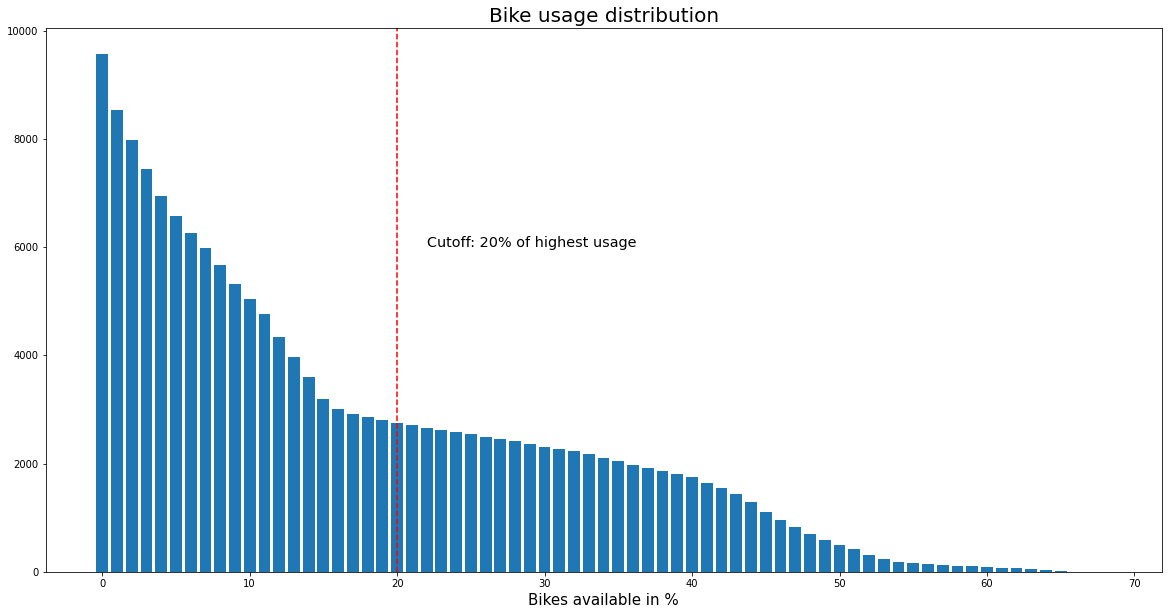

In [12]:
# how is the usage of each bike distributed
# .hist() doesn't work
plt.figure(figsize=(20,10))
plt.title('Bike usage distribution', size=20)
counts = bike_df.Id_Tag_Bicicleta.value_counts()[::66]
y_pos = np.arange(len(counts))
plt.bar(y_pos, counts)
plt.xlabel('Bikes available in %', size=15)
plt.text(x=22, y=6000, s=f'Cutoff: 20% of highest usage', size='x-large')
plt.axvline(20, color='r', linestyle='--')

plt.show()

**Note**<br>
There is a strong elbow visible between the 10th and 20th percentile. Analyzing both parts and their locations might give insight on the efficiency of bike distribution. 

# Most used routes

In [13]:
bike_df['hour'] = bike_df.Fecha_Prestamo.dt.hour

<ipython-input-13-067332580d8f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bike_df['hour'] = bike_df.Fecha_Prestamo.dt.hour


In [14]:
bike_df['routes'] = bike_df.apply(lambda x: f'{x.Id_Aparcamiento_Origen}_{int(x.Id_Aparcamiento_Destino)}', axis=1)
                                  

<ipython-input-14-5e2bf3e2c132>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bike_df['routes'] = bike_df.apply(lambda x: f'{x.Id_Aparcamiento_Origen}_{int(x.Id_Aparcamiento_Destino)}', axis=1)


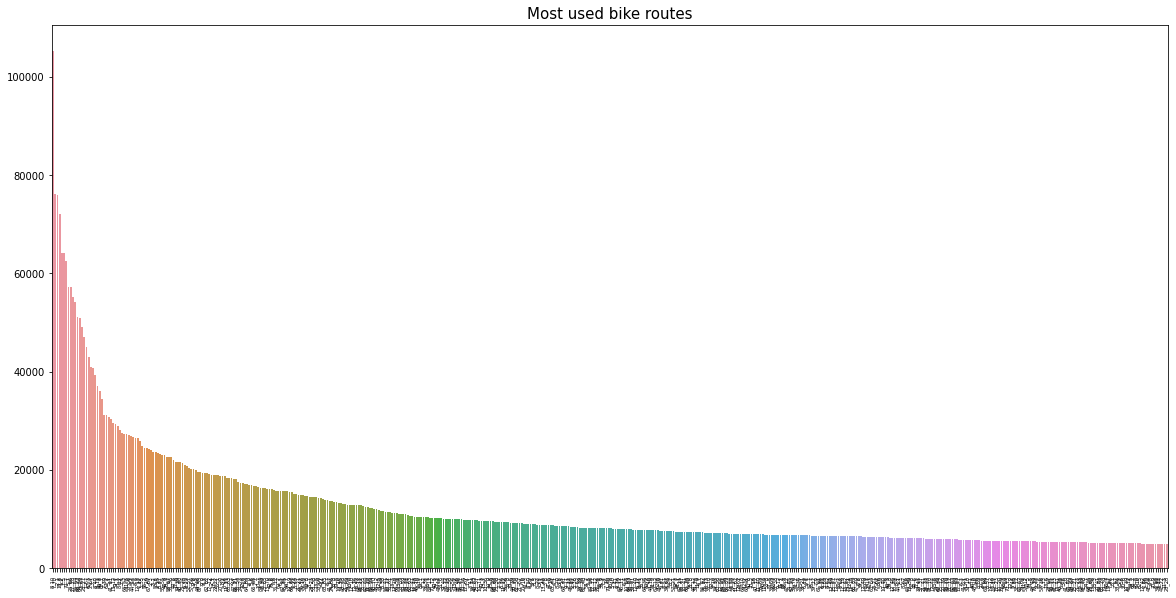

In [15]:
counts = bike_df.routes.value_counts()[:500]
x = counts.keys()
y = list(counts)
plt.figure(figsize=(20,10))
sns.barplot(x=x, y=y)
plt.title('Most used bike routes', size=15)
plt.xticks(rotation=90, size=5)
plt.show()

# rental distribution

In [16]:
bike_df_all['hour'] = bike_df_all.Fecha_Prestamo.dt.hour

In [17]:
# grouping by hour
agg = {'Id_Aparcamiento_Origen':'count', 
      'routes': lambda x: list(x)}
routes_by_hr = bike_df.groupby('hour').agg(agg).rename(columns={'Id_Aparcamiento_Origen':'count_rentals'})

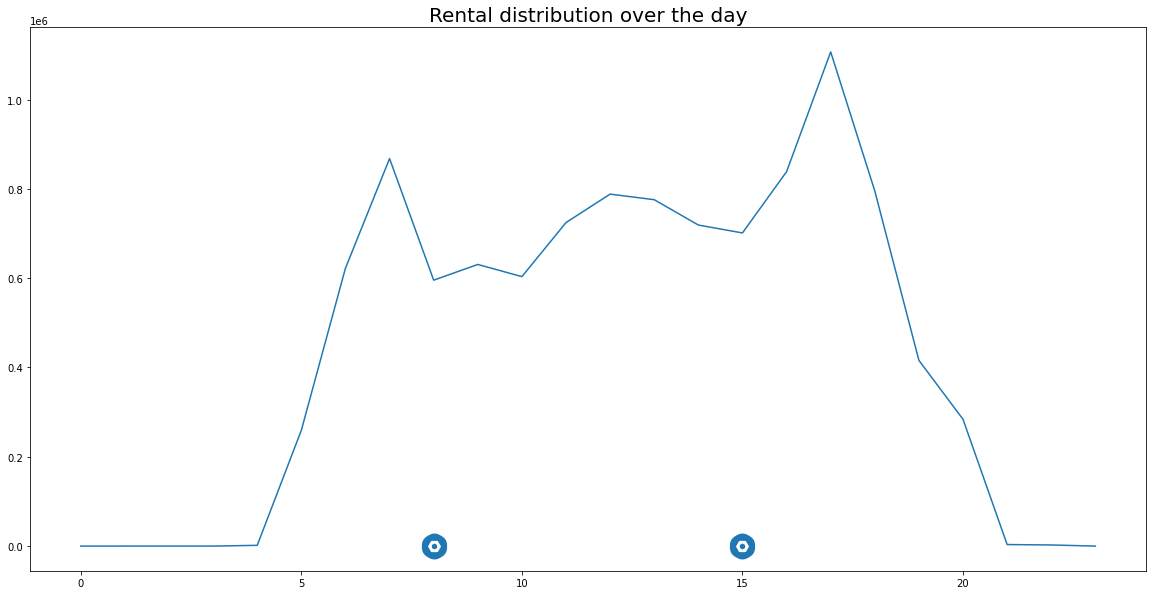

In [18]:
plt.figure(figsize=(20,10))
plt.plot(routes_by_hr.count_rentals)
plt.title('Rental distribution over the day', size=20)
plt.scatter([8,15], [1,1], marker='h', linewidths=20)

## Routes

In [19]:
# count the amount of occuring routes per hour (counting the ocurrences in the lists)
routes_dict = {}
for c, row in routes_by_hr.iterrows():
    routes_dict[c] = dict(Counter(row.routes))

routes_usage = pd.DataFrame.from_dict(routes_dict)

In [20]:
routes_usage['start_id'] = routes_usage.index.map(lambda x: x.split('_')[0])
routes_usage['finish_id'] = routes_usage.index.map(lambda x: x.split('_')[1])
routes_usage['no_move'] = routes_usage.start_id == routes_usage.finish_id

In [21]:
bike_df['timespan_min'] = (bike_df.Fecha_Devolucion - bike_df.Fecha_Prestamo).dt.seconds/60

<ipython-input-21-d8eff50efbbb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bike_df['timespan_min'] = (bike_df.Fecha_Devolucion - bike_df.Fecha_Prestamo).dt.seconds/60


/Users/moritzgeiger/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/moritzgeiger/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


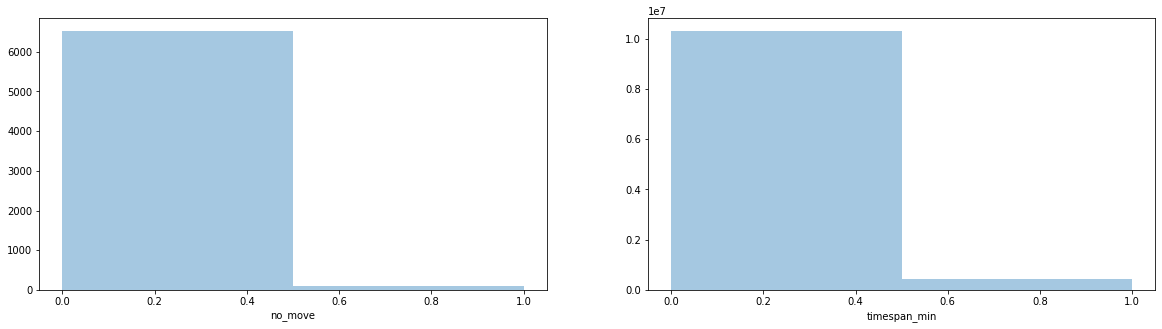

In [22]:
# how many times were bikes returned to the same station
# how many times were bikes rented less than 2 mins
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
sns.distplot(routes_usage.no_move, bins=2, kde=False)
plt.subplot(1,2,2)
under_2 = bike_df.timespan_min < 2
sns.distplot(under_2, bins=2, kde=False)
plt.show()

In [23]:
# take the top5 routes per hour
rank_routes = {}
for hour in routes_usage.columns:
    top3 = dict(routes_usage[hour].sort_values(ascending=False)[:3])
    rank_routes[hour] = top3
rank_routes_df = pd.DataFrame(rank_routes).T

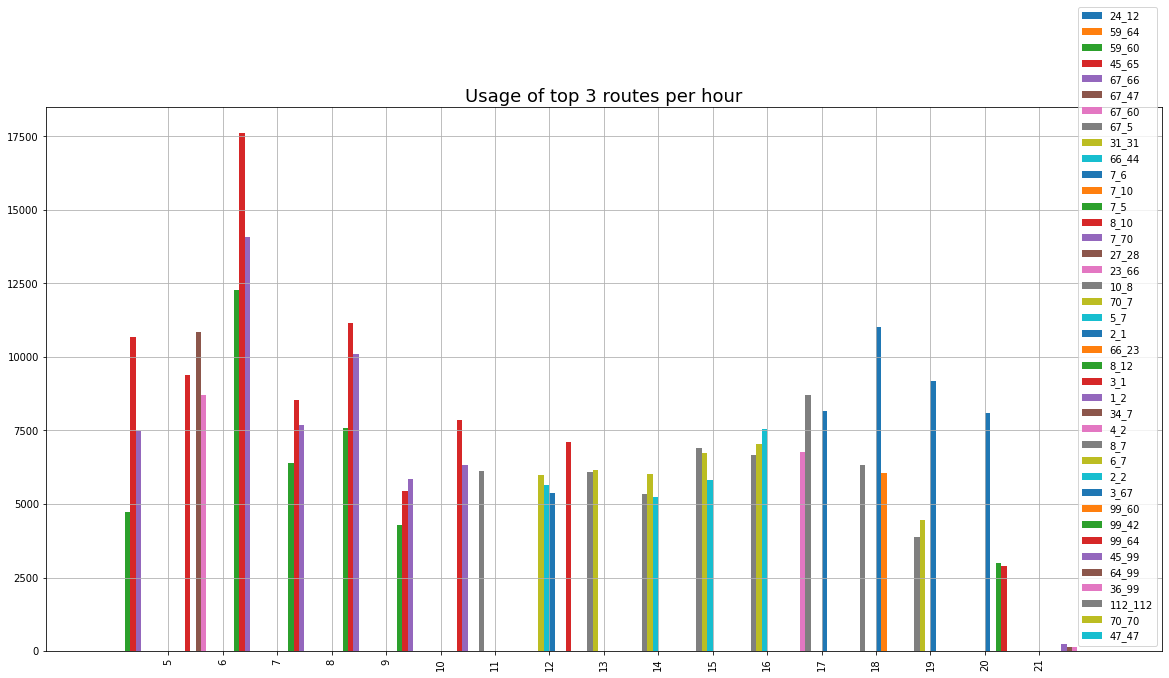

In [24]:
# counts from 0 to 4 in the morning are too low
rank_routes_df.loc[5:21].plot(kind='bar', figsize=(20,10), width=4, stacked=False, align='center')
plt.title('Usage of top 3 routes per hour', size=18)
plt.grid()
plt.show()

**Note**<br>
- In the morning hours the route ```8_10``` is represented in high numbers followed by ```7_70```
- In the evening hours there are more ```2_1``` and ```10_8``` rentals recorded
- Noons and afternoons have a stable distribution of ```70_7``` (returns of the mornings)
- Way less people go back the same way they came from (```8_10``` vs. ```10_8```)

In [25]:
rank_routes

{0: {'24_12': 1.0, '59_64': nan, '59_60': nan},
 1: {'59_64': 3.0, '59_60': 1.0, '45_65': 1.0},
 2: {'67_66': 1.0, '67_47': 1.0, '67_60': 1.0},
 3: {'67_5': 1.0, '31_31': 1.0, '66_44': 1.0},
 4: {'7_6': 121.0, '7_10': 97.0, '7_5': 94.0},
 5: {'8_10': 10661.0, '7_70': 7497.0, '7_5': 4712.0},
 6: {'27_28': 10853.0, '8_10': 9385.0, '23_66': 8706.0},
 7: {'8_10': 17602.0, '7_70': 14072.0, '7_5': 12289.0},
 8: {'8_10': 8541.0, '7_70': 7677.0, '7_5': 6381.0},
 9: {'8_10': 11157.0, '7_70': 10083.0, '7_5': 7571.0},
 10: {'7_70': 5849.0, '8_10': 5455.0, '7_5': 4293.0},
 11: {'8_10': 7866.0, '7_70': 6323.0, '10_8': 6107.0},
 12: {'70_7': 5973.0, '5_7': 5662.0, '2_1': 5360.0},
 13: {'8_10': 7113.0, '70_7': 6170.0, '10_8': 6078.0},
 14: {'70_7': 6015.0, '10_8': 5356.0, '5_7': 5243.0},
 15: {'10_8': 6895.0, '70_7': 6738.0, '5_7': 5818.0},
 16: {'5_7': 7534.0, '70_7': 7028.0, '10_8': 6681.0},
 17: {'10_8': 8721.0, '2_1': 8145.0, '23_66': 6759.0},
 18: {'2_1': 11005.0, '10_8': 6330.0, '66_23': 6053.0

In [26]:
# add a map with circle markers and polylines and weigh them by usage with ipywidgets interact per hour. 
## as soon as we have the coordinates

## Pandemic analysis

In [27]:
bike_df_all['month'] = bike_df.Fecha_Prestamo.dt.month

In [28]:
# bike_df_all.groupby('month').count()['Fecha_Prestamo'].T.sort_values().plot()

## most used bike

In [29]:
# extract the most used bike for faster computation
most_used = bike_df_all.Id_Tag_Bicicleta.value_counts().keys()[0]
most_used_df = bike_df_all[bike_df_all.Id_Tag_Bicicleta == most_used]
most_used_df['day'] = most_used_df['Fecha_Prestamo'].dt.strftime('%Y/%m/%d')

<ipython-input-29-d5a6e96cc395>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  most_used_df['day'] = most_used_df['Fecha_Prestamo'].dt.strftime('%Y/%m/%d')


In [30]:
# assign routes as tuples
most_used_df = most_used_df.dropna()
most_used_df['routes'] = most_used_df.apply(lambda x: (x.Id_Aparcamiento_Origen, int(x.Id_Aparcamiento_Destino)), axis=1)

In [31]:
most_used_df

,Id_Historico_Prestamo,Id_Usuario,Id_Tag_Bicicleta,Fecha_Prestamo,Fecha_Devolucion,Id_Aparcamiento_Origen,Posicion_Origen,Id_Aparcamiento_Destino,Posicion_Destino,Num_Bici_Hist,covid,hour,month,day,routes
3545,6426679,97869,000017AFC4CF,2017-06-09 11:04:16,2017-06-09 11:18:02,12,1,13.0,1.0,1162.0,False,11,6.0,2017/06/09,"(12, 13)"
3767,6427011,38435,000017AFC4CF,2017-06-09 11:42:01,2017-06-09 11:58:58,7,1,42.0,4.0,1162.0,False,11,6.0,2017/06/09,"(7, 42)"
5268,6424861,98946,000017AFC4CF,2017-06-09 07:24:50,2017-06-09 07:33:58,7,1,70.0,1.0,1162.0,False,7,6.0,2017/06/09,"(7, 70)"
5450,6424992,93635,000017AFC4CF,2017-06-09 07:37:17,2017-06-09 07:49:00,70,1,10.0,1.0,1162.0,False,7,6.0,2017/06/09,"(70, 10)"
6321,6430956,11026,000017AFC4CF,2017-06-09 17:21:38,2017-06-09 17:44:43,55,1,8.0,1.0,1162.0,False,17,6.0,2017/06/09,"(55, 8)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7773547,10312842,98493,000017AFC4CF,2018-11-23 18:04:28,2018-11-23 18:29:39,41,1,1.0,1.0,1162.0,False,18,11.0,2018/11/23,"(41, 1)"
7774616,10308201,33027,000017AFC4CF,2018-11-23 12:18:05,2018-11-23 12:34:07,34,1,53.0,5.0,1162.0,False,12,11.0,2018/11/23,"(34, 53)"
7775583,10309427,100577,000017AFC4CF,2018-11-23 13:56:40,2018-11-23 14:07:49,53,1,70.0,1.0,1162.0,False,13,11.0,2018/11/23,"(53, 70)"
7775872,10309680,19218,000017AFC4CF,2018-11-23 14:12:01,2018-11-23 14:28:06,70,1,46.0,4.0,1162.0,False,14,11.0,2018/11/23,"(70, 46)"


In [32]:
# day_df[day_df == day_df.max()].index[0]

In [33]:
most_used_df.routes.value_counts()

(8, 10)     116
(10, 8)      82
(7, 5)       77
(2, 1)       76
(3, 3)       65
           ... 
(34, 19)      1
(35, 53)      1
(2, 48)       1
(55, 7)       1
(55, 40)      1
Name: routes, Length: 2127, dtype: int64

Busiest day 2017/06/16 with 50 rentals for ID 000017AFC4CF


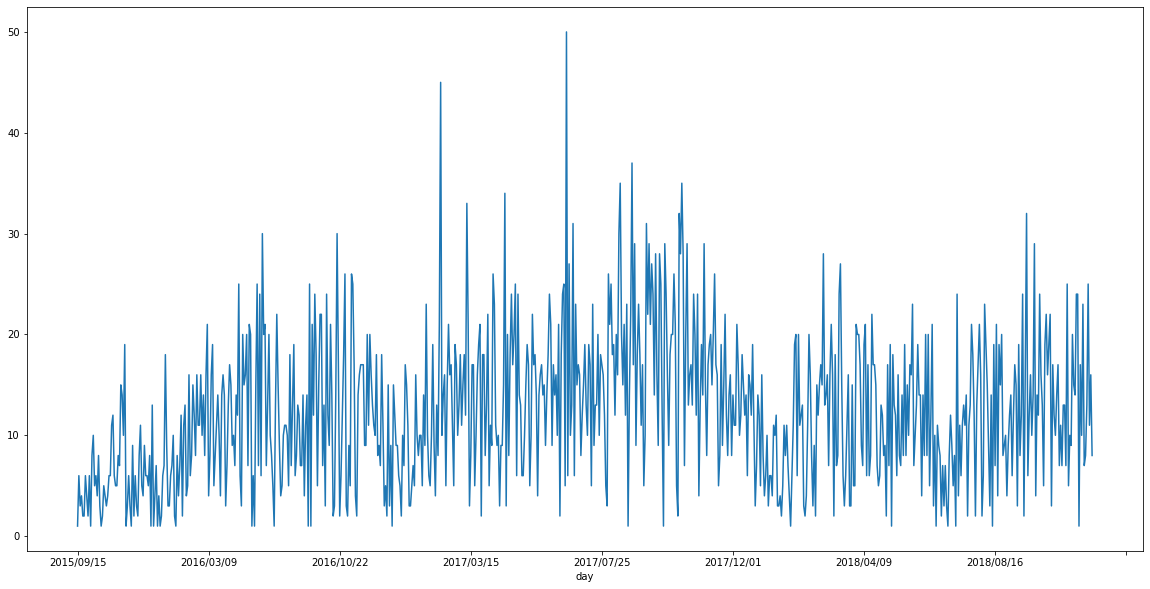

In [34]:
# follow the most used bike by day
day_df = most_used_df.groupby('day').count().sort_index()['Id_Usuario']
day_df.plot(figsize=(20,10))
print(f'Busiest day {day_df[day_df == day_df.max()].index[0]} with {day_df.max()} rentals for ID {most_used}')

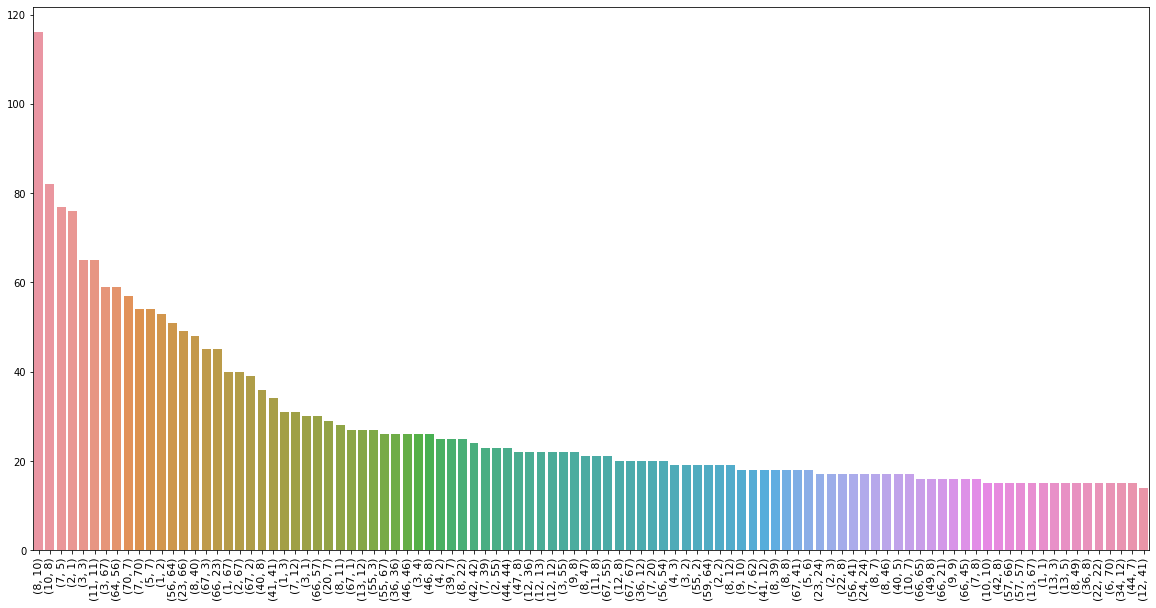

In [35]:
# by route
counts = most_used_df.routes.value_counts()[:100]
x = counts.keys()
y = list(counts)
plt.figure(figsize=(20,10))
sns.barplot(x=x, y=y)
plt.xticks(rotation=90, size=11)
plt.show()

# Map stations

In [36]:
stations_df = pd.read_csv('raw_data/stations.csv')
stations_coords = stations_df.groupby('Station_ID').first()[['Station_name', 
                                          'Station_address',
                                          'Station_description',
                                          'Station_latitude', 
                                          'Station_longitude']]

In [37]:
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'
stations_gdf = gpd.read_file('raw_data/medellin_bike_stations.kml.xml', driver='KML')

In [38]:
# stations_coords

In [39]:
stations_coords['longlat'] = stations_coords.apply(lambda x: (x['Station_longitude'], x['Station_latitude']), axis=1)
                                                                                      

In [40]:
def app_coords(x):
    x['start_coord'] = None
    x['finish_coord'] = None
    for c, row in x.iterrows():
        start = float(row.start_id)
        try:
            x.at[c, 'start_coord'] = stations_coords.loc[start, 'longlat']
        except Exception as e:
            continue
        stop = float(row.finish_id)
        try:
            x.at[c, 'finish_coord'] = stations_coords.loc[stop, 'longlat']
        except:
            continue
    
    return x

In [41]:
# wont be neccessary if official source avail
routes_usage_x = routes_usage.copy()
routes_usage_x = app_coords(routes_usage_x)
routes_usage_x = routes_usage_x.rename(columns={i:str(i) for i in routes_usage_x.columns}) # to align with later csv read

In [42]:
# retrieve bike routes
load_dotenv(find_dotenv())
HERE_API = os.environ.get("HERE_API")
def here_routes(x):
#     x = x.dropna(subset=['start_coord', 'finish_coord'])
    if x.start_coord and x.finish_coord:
        base_url = 'https://route.ls.hereapi.com/routing/7.2/calculateroute.json'
        start = f'{x.start_coord[1]},{x.start_coord[0]}'
        stop = f'{x.finish_coord[1]},{x.finish_coord[0]}'
        params_i = {'apiKey':HERE_API,
                    'waypoint0':f'geo!{start}',
                    'waypoint1':f'geo!{stop}',
                    'mode':'shortest;bicycle;traffic:disabled'
    #                     'jsonattributes':'9'
                   }
        ri = requests.get(url=base_url, params=params_i)
        lst = []
        try:
            for i in ri.json()['response']['route'][0]['leg'][0]['maneuver']:
                lat = i.get('position').get('latitude')
                long = i.get('position').get('longitude')
                lst.append((long, lat))
            line = LineString(lst)
            print(line)
            return line
        except Exeption as e:
            print(f'Couldn\'t get route {start}, {stop}, Error: {e}')

In [43]:
# reload file after saving
routes_usage_x = pd.read_csv('raw_data/routes_usage.csv', 
                             index_col=0, 
                             converters={'start_coord':ast.literal_eval}).dropna(subset=['geometry'])
routes_usage_x = gpd.GeoDataFrame(routes_usage_x)
routes_usage_x['geometry'] = routes_usage_x['geometry'].apply(wkt.loads)

In [44]:
# dont run if routes already retrieved
# save all retrieved data before assigning
if 'routes_dict' not in locals():
    routes_dict = {}
if 'geometry' not in routes_usage_x.columns:
    routes_usage_x['geometry'] = None
for c, row in routes_usage_x.iterrows():
    if not row.geometry:
        line = here_routes(row)
        routes_dict[c] = line
        routes_usage_x.at[c, 'geometry'] = line
    else:
        print(f'satisfied with: {c}')

routes_usage_x.to_csv('raw_data/routes_usage.csv')

satisfied with: 24_12
satisfied with: 59_64
satisfied with: 59_60
satisfied with: 45_65
satisfied with: 1_10
satisfied with: 22_22
satisfied with: 67_66
satisfied with: 67_47
satisfied with: 67_60
satisfied with: 67_45
satisfied with: 67_5
satisfied with: 67_2
satisfied with: 67_19
satisfied with: 67_56
satisfied with: 59_46
satisfied with: 34_32
satisfied with: 66_44
satisfied with: 66_8
satisfied with: 62_62
satisfied with: 66_24
satisfied with: 7_13
satisfied with: 34_67
satisfied with: 7_4
satisfied with: 7_12
satisfied with: 7_8
satisfied with: 7_2
satisfied with: 7_38
satisfied with: 7_10
satisfied with: 7_21
satisfied with: 5_5
satisfied with: 5_21
satisfied with: 7_9
satisfied with: 7_67
satisfied with: 7_6
satisfied with: 7_5
satisfied with: 7_22
satisfied with: 7_1
satisfied with: 21_13
satisfied with: 34_43
satisfied with: 7_7
satisfied with: 7_49
satisfied with: 59_53
satisfied with: 59_19
satisfied with: 2_1
satisfied with: 7_54
satisfied with: 7_47
satisfied with: 7_70
sa

satisfied with: 49_56
satisfied with: 11_6
satisfied with: 64_24
satisfied with: 33_12
satisfied with: 58_38
satisfied with: 46_64
satisfied with: 21_40
satisfied with: 51_60
satisfied with: 13_57
satisfied with: 4_57
satisfied with: 45_13
satisfied with: 45_44
satisfied with: 54_47
satisfied with: 41_45
satisfied with: 10_60
satisfied with: 42_19
satisfied with: 13_40
satisfied with: 65_41
satisfied with: 13_39
satisfied with: 13_42
satisfied with: 55_47
satisfied with: 42_53
satisfied with: 22_42
satisfied with: 6_37
satisfied with: 11_60
satisfied with: 46_62
satisfied with: 49_48
satisfied with: 61_36
satisfied with: 36_41
satisfied with: 42_44
satisfied with: 4_39
satisfied with: 65_9
satisfied with: 13_62
satisfied with: 46_48
satisfied with: 34_48
satisfied with: 6_12
satisfied with: 1_49
satisfied with: 20_58
satisfied with: 62_9
satisfied with: 65_12
satisfied with: 43_47
satisfied with: 42_60
satisfied with: 22_2
satisfied with: 10_40
satisfied with: 42_1
satisfied with: 36_7

satisfied with: 24_95
satisfied with: 95_42
satisfied with: 92_45
satisfied with: 47_96
satisfied with: 90_46
satisfied with: 96_93
satisfied with: 92_2
satisfied with: 95_51
satisfied with: 92_19
satisfied with: 22_93
satisfied with: 96_70
satisfied with: 42_97
satisfied with: 95_91
satisfied with: 99_56
satisfied with: 65_100
satisfied with: 96_66
satisfied with: 9_97
satisfied with: 5_97
satisfied with: 53_97
satisfied with: 90_13
satisfied with: 60_70
satisfied with: 61_70
satisfied with: 91_56
satisfied with: 63_57
satisfied with: 97_20
satisfied with: 99_63
satisfied with: 45_98
satisfied with: 98_70
satisfied with: 95_39
satisfied with: 34_98
satisfied with: 96_5
satisfied with: 96_59
satisfied with: 96_53
satisfied with: 94_1
satisfied with: 97_7
satisfied with: 6_63
satisfied with: 94_54
satisfied with: 92_56
satisfied with: 40_92
satisfied with: 97_39
satisfied with: 59_100
satisfied with: 62_60
satisfied with: 92_59
satisfied with: 59_43
satisfied with: 91_10
satisfied with:

satisfied with: 108_89
satisfied with: 92_95
satisfied with: 115_97
satisfied with: 99_90
satisfied with: 118_45
satisfied with: 67_108
satisfied with: 22_92
satisfied with: 51_90
satisfied with: 109_65
satisfied with: 118_4
satisfied with: 110_111
satisfied with: 108_60
satisfied with: 105_34
satisfied with: 109_89
satisfied with: 60_108
satisfied with: 102_5
satisfied with: 113_64
satisfied with: 22_99
satisfied with: 108_118
satisfied with: 110_118
satisfied with: 110_96
satisfied with: 111_59
satisfied with: 7_118
satisfied with: 118_109
satisfied with: 39_27
satisfied with: 110_109
satisfied with: 115_56
satisfied with: 102_10
satisfied with: 115_19
satisfied with: 92_89
satisfied with: 105_41
satisfied with: 115_59
satisfied with: 111_106
satisfied with: 108_13
satisfied with: 114_96
satisfied with: 111_19
satisfied with: 105_55
satisfied with: 106_105
satisfied with: 27_45
satisfied with: 102_37
satisfied with: 118_100
satisfied with: 114_56
satisfied with: 106_111
satisfied wit

In [45]:
(routes_usage_x.geometry == routes_usage_x.geometry).sum()

5720

In [46]:
# plot route density
def mapa(hour, show_routes, show_stations):
    hour = str(hour) # col names are read in str
    m = folium.Map([6.25, -75.58], zoom_start=13, tiles='cartodbpositron')
    
    hour_df = routes_usage_x[routes_usage_x[hour] == routes_usage_x[hour]][[hour, 'start_id', 'start_coord', 'geometry']]
    hour_df = hour_df[hour_df.geometry == hour_df.geometry].sort_values(by=hour, ascending=False)
    hour_df = hour_df.dropna().head(100)
    hour_df = gpd.GeoDataFrame(hour_df)
    
    # routes
    cmap = matplotlib.cm.get_cmap('BuPu')
    routes = FeatureGroup(name='Routes', show=show_routes)
    stations = FeatureGroup(name='Stations', show=show_stations)
    for c, row in hour_df.iterrows():
        # routes
        hexa = matplotlib.colors.to_hex(cmap(row[hour]/hour_df[hour].max()))
        xy = row.geometry.coords.xy
        coords = [[x[i] for x in [xy[1], xy[0]]] for i in range(len(xy[0]))]
        folium.PolyLine(coords, 
                        color=hexa, 
                        weight=10, 
                        tooltip=f'Route: {c}',
                        opacity=.3).add_to(routes)
    # circles
    pickup_df = hour_df.groupby('start_id').agg({hour:'sum', 'start_coord':'first'})
    cmapa = matplotlib.cm.get_cmap('YlOrRd')

    for c, row in pickup_df.iterrows():
        size = (np.sqrt(row[hour])/19)**2
        hexe = matplotlib.colors.to_hex(cmapa(row[hour]/hour_df[hour].max()))

        CircleMarker((row.start_coord[1],row.start_coord[0]), 
                     radius=size, 
                     fill=True, 
                     tooltip=f'Station: {c}', 
                     color=hexe,
                     weight=0,
                     fill_opacity=.2
                    ).add_to(stations)

    
    stations.add_to(m)
    routes.add_to(m)
    LayerControl().add_to(m)
    return m

interact(mapa, hour=IntSlider(min=5, max=21, step=1, value=8), show_routes=True, show_stations=True)

interactive(children=(IntSlider(value=8, description='hour', max=21, min=5), Checkbox(value=True, description=…

<function __main__.mapa(hour, show_routes, show_stations)>

# Locate individual bike at station

In [102]:
# filter to 2019 data
bikes_19 = bike_df_all[bike_df_all.Fecha_Devolucion.dt.year == 2019].reset_index()

In [104]:
# assign df a individual hour of the year per row
def get_hr(x):
    time = x
    hour = dt.datetime(time.year, time.month,time.day,time.hour)
    return hour
    
bikes_19.loc[:,'hour'] = bikes_19.Fecha_Devolucion.apply(get_hr)

In [144]:
# make sure df is sorted chronologically
bikes_19 = bikes_19.sort_values(by='Fecha_Devolucion')

# list all the appearing bikes and stations per individual hour of the year
bikes_19_by_bike = bikes_19.copy().groupby('hour').agg({'Id_Tag_Bicicleta':lambda x: list(x), 'Id_Aparcamiento_Destino':lambda x: list(x)})

# only keep the _last_ entry of a bike per hour (dict will overwrite)
bikes_19_by_bike['bikes_loc'] = None
for c, row in bikes_19_by_bike.iterrows():
#     print(c) # check progress
    dct = {}
    for i, bike in enumerate(row.Id_Tag_Bicicleta):
        dct[bike] = row.Id_Aparcamiento_Destino[i]
    bikes_19_by_bike.at[c, 'bikes_loc'] = dct

# move hour to columns and only leave the dict
bikes_19_by_bike = bikes_19_by_bike[['bikes_loc']].reset_index()

# count the appearance of each station per hour
bikes_19_by_bike['station_count'] = None
for c, row in bikes_19_by_bike.iterrows():
    stations = row.bikes_loc.values()
    for station in stations:
        dct = dict(Counter(stations))
    bikes_19_by_bike.at[c, 'station_count'] = dct
        

# make dict column visible
bikes_19_by_bike.head(50).style.set_properties(subset=['bikes_loc'], **{'width': '300px'})

In [ ]:
bikes_19_by_bike.to_csv('raw_data/stations_count_hr.csv')